In [1]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
import torch
import os
import sys
from torch.utils import data
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')

from utils import utils, model_fetch, dataloader
metrics_dict = {}

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Which model to evaluate


####### Change This #######
model_of_interest = "augmented_teacher"
###########################
_CLASSES = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

base_path = '../distillation_experiments/runs/'

MODEL_DIRS = {
    "baseline_teacher": base_path + 'resnet18_baseline_retrained_1586751743/model_best.pth.tar',
    "mixup_teacher": base_path + 'resnet18_mixup_retrained_1586457991/checkpoint.pth.tar',
    "cutout_teacher": base_path + 'resnet18-cutout-restart-again_1586956477/model_best.pth.tar',
    "cutmix_teacher": base_path + 'resnet18_cutmix_retrained_1587147326-20200423T211700Z-001/model_best.pth.tar',
    "augmented_teacher": base_path + 'resnet18_augmented_retrained_1586751381/checkpoint.pth.tar',
    
    "baseline": base_path + 'student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar', 
    "mixup" : base_path + 'student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar',
    "cutout": base_path + 'lenet-student-cutout_1587345858/model_best.pth.tar',
    "cutmix": base_path + 'student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar',
    "augmented": base_path + ''
}
if 'teacher' in model_of_interest:
    model = model_fetch.fetch_student('resnet18')
else:
    model = model_fetch.fetch_student('lenet')

_, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_of_interest])
model.eval()

=> Loading Checkpoint '../distillation_experiments/runs/resnet18_augmented_retrained_1586751381/checkpoint.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/resnet18_augmented_retrained_1586751381/checkpoint.pth.tar' (epoch 221)
Current Loss :  0.2427171825230876


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [3]:
# Loading both test sets - CIFAR and CIFAR - 10H -- Images are same.

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# CIFAR-10H data
data_prob = np.load('../data/cifar-10h/cifar10h-probs.npy')
data_counts = np.load('../data/cifar-10h/cifar10h-counts.npy')

# CIFAR Data
file_path = '../data/data-cifar-10/cifar-10-batches-py/test_batch'
label_dict = unpickle(file_path)

# Labels for both data
human_labels = data_prob.argmax(axis=1)
cifar_labels = label_dict[b'labels'] 

# print(label_dict.keys())

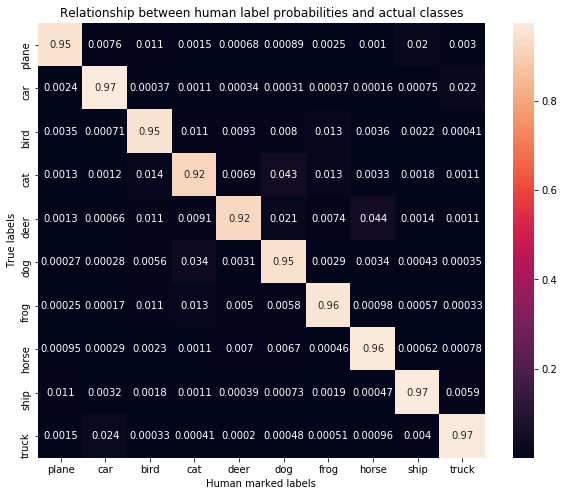

In [4]:
# Create conf-matrix like proba-distribution visualization for human labels
# Ground each human proba for an image on the ground truth and find the distribution for each GT class(rows)
if True:
    human_conf = np.zeros((10,10))
    for i, prob in enumerate(data_prob):
        gt_label = cifar_labels[i]
        human_conf[gt_label] += prob

    human_counts = np.unique(human_labels, return_counts=True)
    for i, count in enumerate(human_counts[1]):
        human_conf[i] /= count

    # Diagonal elements set to zero so that other correlations are enhanced
    human_conf2 = np.zeros((10,10))
    for i in range(len(human_conf)):
        for j in range(len(human_conf[0])):
            if i != j:
                human_conf2[i][j] = human_conf[i][j]


    fig = plt.figure(figsize=(10,8))

    ax = fig.add_subplot()
    sns.heatmap(human_conf, annot=True, ax = ax); #annot=True to annotate cells  

    ax.set_xlabel('Human marked labels')
    ax.set_ylabel('True labels')
    ax.set_title('Relationship between human label probabilities and actual classes')
    ax.xaxis.set_ticklabels(_CLASSES)
    ax.yaxis.set_ticklabels(_CLASSES)

In [5]:
# Create PyTorch dataset for CIFAR images

data = label_dict[b'data'].reshape((10000, 3, 32, 32))
data= data.transpose((0,2,3,1))
dataset = dataloader.MyDataset(data, cifar_labels)

In [6]:
# Create softmax preds from model using above dataset
if True:
    preds = []
    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        img = img.unsqueeze(0)
        softmax = torch.nn.Softmax(dim=1)
        pred = softmax(model(img))
        preds.append(pred.detach().numpy())
    #     break
    preds = np.array(preds).squeeze(axis=1)
    preds.shape

100%|██████████| 10000/10000 [02:51<00:00, 58.29it/s]


In [7]:
# Create Embedding generating Model
if True:
    embed_model = model
    class Identity(torch.nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, x):
            return x
    embed_model.linear = Identity()

In [8]:
if True:
    embeds = []

    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        img = img.unsqueeze(0)
        embedding = embed_model(img).detach().numpy().squeeze(0)
        embeds.append(embedding)
    embeds = np.array(embeds)
    embeds.shape

100%|██████████| 10000/10000 [02:44<00:00, 60.65it/s]


In [9]:
if False:
    preds_path =  '../../results/preds/' +model_of_interest+ '.npy'
    preds = np.load(preds_path)

In [10]:
if True:
    save_path_embeds = '../../results/embeddings/' + model_of_interest+ '.npy'
    np.save(save_path_embeds, embeds)
    save_path_preds = '../../results/preds/' +model_of_interest+ '.npy'
    np.save(save_path_preds, preds)

In [11]:
# Update existing Metrics Dictionary for CIFAR classification

metrics = utils.find_metrics(preds, np.array(cifar_labels), False)
metrics_df = metrics_dict.update({model_of_interest:
    {
        "accuracy": metrics[0],
        "precision": metrics[1],
        "recall": metrics[2],
        "f1-score": metrics[3]
    }})

pd.DataFrame(metrics_dict)

,augmented_teacher
accuracy,0.940300
f1-score,0.940312
precision,0.940369
recall,0.940300


[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

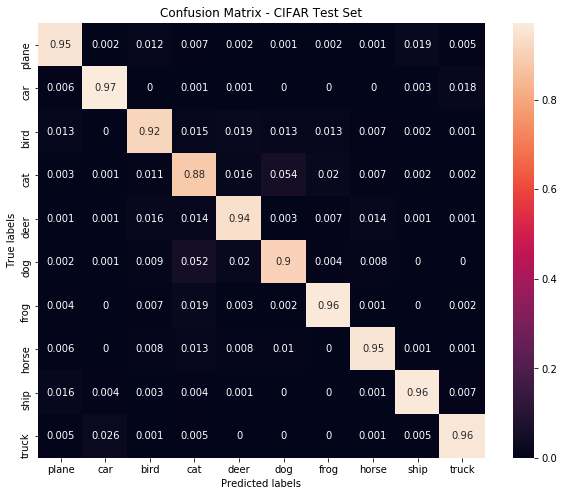

In [12]:
# CIFAR test set Confusion Matrix

y_preds = np.argmax(preds, axis=1)
y_true = cifar_labels
conf_mat = cm(y_true, y_preds, normalize='true')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - CIFAR Test Set')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

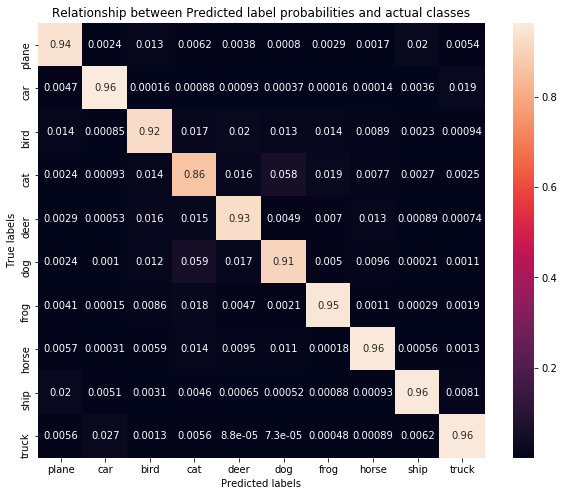

In [13]:
# Create conf-matrix like proba-distribution visualization for model labels
# Ground each model proba for an image on the ground truth and find the distribution for each GT class(rows)


pred_counts = np.unique(np.argmax(preds, axis=1), return_counts=True)[1]
# print(pred_counts)
pred_conf = np.zeros((10,10))
for i, prob in enumerate(preds):
    gt_label = cifar_labels[i]
    pred_conf[gt_label] += prob

for i, count in enumerate(pred_counts):
    pred_conf[i] /= count

# Diagonal elements set to zero so that other correlations are enhanced
pred_conf2 = np.zeros((10,10))
for i in range(len(pred_conf)):
    for j in range(len(pred_conf[0])):
        if i != j:
            pred_conf2[i][j] = pred_conf[i][j]
    
fig = plt.figure(figsize=(10,8))
  
ax = fig.add_subplot()
sns.heatmap(pred_conf, annot=True, ax = ax); #annot=True to annotate cells  

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Relationship between Predicted label probabilities and actual classes')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

0.013750808654341534


[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

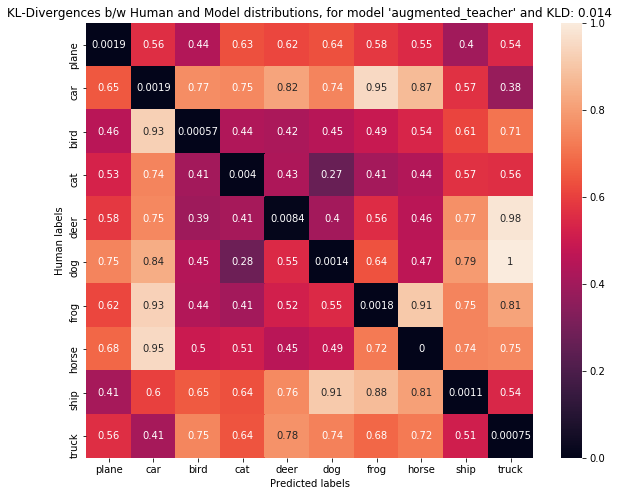

In [14]:
# KL Divergence plot between human labels and model labels
# Ideally, if a model is generalized well, KL Divergence between similar classes = low
# Relevant KLD is across proba distributions of the same class

def kl_div(actual, pred):
    return np.sum(np.where(actual != 0, actual * np.log(actual/pred), 0))

kldiv_matrix = np.zeros((10,10))
relevant_kld = 0
for i in range(len(human_conf)):
    for j in range(len(human_conf[0])):
        kldiv_matrix[i][j] = kl_div(human_conf[i], pred_conf[j])
        if i == j:
            relevant_kld += kldiv_matrix[i][j]
            
print(relevant_kld/10.0)
fig = plt.figure(figsize=(10,8))

kldiv_matrix_norm = (kldiv_matrix - np.min(kldiv_matrix))/np.ptp(kldiv_matrix)

  
ax = fig.add_subplot()
sns.heatmap(kldiv_matrix_norm, annot=True, ax = ax); #annot=True to annotate cells  

ax.set_xlabel('Predicted labels')
ax.set_ylabel('Human labels')
ax.set_title('KL-Divergences b/w Human and Model distributions, for model \'{}\' and KLD: {}'.format(model_of_interest, round(relevant_kld/10, 3)))
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

In [15]:
pd.DataFrame(metrics_dict)

,augmented_teacher
accuracy,0.940300
f1-score,0.940312
precision,0.940369
recall,0.940300


In [20]:
METRICS_STUDENT_DICT = {
    "cutout":{
        "accuracy": 0.644200,
        "precision": 0.643208,
        "recall": 0.644200,
        "f1-score": 0.643570,
        "kl-divergence":0,
    },
    "baseline": {
        "accuracy": 0.652000,
        "precision": 0.648755,
        "recall": 0.652000,
        "f1-score": 0.650052,
        "kl-divergence":0.388,
    },
     "mixup": {
        "accuracy": 0.633500,
        "precision": 0.630683,
        "recall": 0.633500,
        "f1-score": 0.631768,
        "kl-divergence":0.537,
     },
     "cutmix": {
        "accuracy": 0.621300,
        "precision": 0.617724,
        "recall": 0.621300,
        "f1-score": 0.619058,
        "kl-divergence":0.536,        
     },
     "cutout": {
        "accuracy": 0.644200,
        "precision": 0.643208,
        "recall": 0.644200,
        "f1-score": 0.643570,
        "kl-divergence":0.418,      
     },

}


In [18]:
METRICS_TEACHER_DICT = {
    "teacher_baseline": {
        "accuracy": 0.851800,
        "precision": 0.851305,
        "recall": 0.851800,
        "f1-score": 0.851465,
        "kl-divergence":0.081,
    },
     "teacher_mixup": {
        "accuracy": 0.867700,
        "precision": 0.954327,
        "recall": 0.867700,
        "f1-score": 0.954286,
        "kl-divergence":0.224,
     },
     "teacher_cutmix": {
        "accuracy": 0.954300,
        "precision": 0.869071,
        "recall": 0.954300,
        "f1-score": 0.867853,
        "kl-divergence":0.016,
     },
    "teacher_cutout": {
        "accuracy": 0.879600,
        "precision": 0.878731,
        "recall": 0.879600,
        "f1-score": 0.878999,
        "kl-divergence":0.051,
    },
    "teacher_augmented": {
        "accuracy": 0.940300,
        "precision": 0.940369,
        "recall": 0.940300,
        "f1-score": 0.940312,
        "kl-divergence":0.014,
     }
}


In [19]:
pd.DataFrame(METRICS_TEACHER_DICT)

,teacher_baseline,teacher_mixup,teacher_cutmix,teacher_cutout,teacher_augmented
accuracy,0.851800,0.867700,0.954300,0.879600,0.940300
precision,0.851305,0.954327,0.869071,0.878731,0.940369
recall,0.851800,0.867700,0.954300,0.879600,0.940300
f1-score,0.851465,0.954286,0.867853,0.878999,0.940312
kl-divergence,0.081000,0.224000,0.016000,0.051000,0.014000


In [21]:
pd.DataFrame(METRICS_STUDENT_DICT)

,cutout,baseline,mixup,cutmix
accuracy,0.644200,0.652000,0.633500,0.621300
precision,0.643208,0.648755,0.630683,0.617724
recall,0.644200,0.652000,0.633500,0.621300
f1-score,0.643570,0.650052,0.631768,0.619058
kl-divergence,0.418000,0.388000,0.537000,0.536000
